In [1]:
import torch
import torchvision
import torch.nn as nn
# 0. Use device to acclerate experiment time

In [2]:
import random
import matplotlib.pyplot as plt

n = 16
N = 100
# 1. 100 is not enough, 10000 should do the job

x_list = []
y_list = []

for i in range(N):
    x = torch.linspace(-1, 1, n)
    mode = random.randint(0, 1)
    if mode == 0:
        y = torch.linspace(-2, 2, n)
    else:
        y = torch.linspace(2, -2, n)
    
    noise_x = 0.02 * torch.randn(n)
    noise_y = 0.02 * torch.randn(n)
    x = x + noise_x
    y = y + noise_y
    x_list.append(x)
    y_list.append(y)

x = torch.stack(x_list)
y = torch.stack(y_list)

data = torch.stack((x, y), dim=1)
print(data.shape)


torch.Size([100, 2, 16])


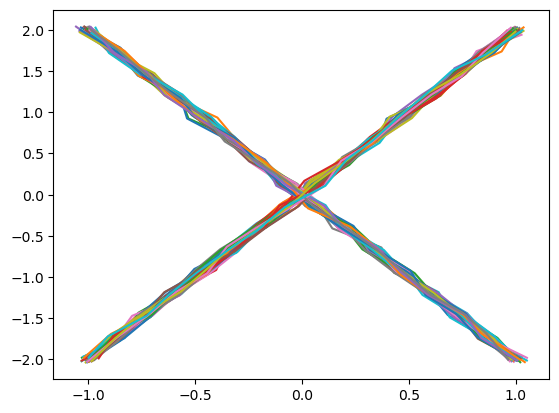

In [3]:
plt.plot(data[:, 0, :].transpose(0, 1), data[:, 1, :].transpose(0, 1));

In [4]:
'''
Define a sequence of sigma_t's.
'''
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "constant":
        betas = torch.ones(n_timesteps) * start
    return betas

In [5]:
"""initialize diffusion-related constant"""
beta_schedule = 'linear'
n_timesteps = 1000
beta_start, beta_end = 1e-3, 1e-2
# beta_start, beta_end = 1e-4, 1e-3
betas = make_beta_schedule(
    schedule=beta_schedule,
    n_timesteps=n_timesteps,
    start=beta_start,
    end=beta_end,
)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [6]:
def q_sample(x_start, t):
    global alphas_bar_sqrt, one_minus_alphas_bar_sqrt
    noise = torch.randn(*x_start.shape, device=x_start.device)
    x_t = alphas_bar_sqrt[t - 1] * x_start + one_minus_alphas_bar_sqrt[t - 1] * noise
    return x_t

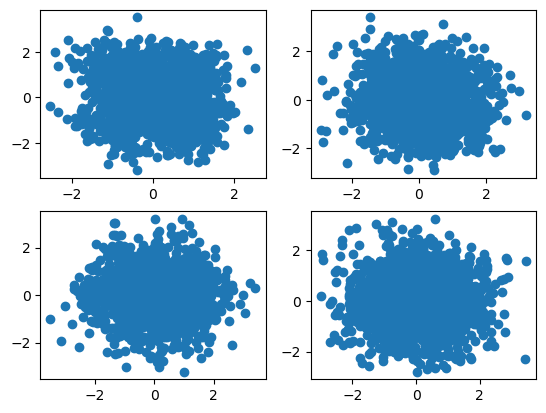

In [7]:
fig = plt.figure()
data = data

data_diffused = q_sample(data, 250)

ax = fig.add_subplot(2, 2, 1)
ax.scatter(data_diffused[:, 0, :], data_diffused[:, 1, :])

data_diffused = q_sample(data, 500)

ax = fig.add_subplot(2, 2, 2)
ax.scatter(data_diffused[:, 0, :], data_diffused[:, 1, :])

data_diffused = q_sample(data, 750)

ax = fig.add_subplot(2, 2, 3)
ax.scatter(data_diffused[:, 0, :], data_diffused[:, 1, :])

data_diffused = q_sample(data, 1000)

ax = fig.add_subplot(2, 2, 4)
ax.scatter(data_diffused[:, 0, :], data_diffused[:, 1, :])

# print(torch.std_mean(data, dim = 0))
# print(torch.std_mean(latent_diffused, dim = 0))

In [8]:
batch_size = 32
n_class = 1

In [9]:
import torch
from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D, Summer

# Returns the position encoding only
p_enc_1d_model = PositionalEncoding1D(10)

# Return the inputs with the position encoding added
p_enc_1d_model_sum = Summer(PositionalEncoding1D(10))

x = torch.rand(1,6,10)
penc_no_sum = p_enc_1d_model(x) # penc_no_sum.shape == (1, 6, 10)
penc_sum = p_enc_1d_model_sum(x)

In [10]:
from positional_encodings.torch_encodings import PositionalEncoding3D, PositionalEncoding1D

#3. I think this version is better
def time_embed(time_length, feature_dim):
  pos_encoder = PositionalEncoding1D(feature_dim)
  z = torch.zeros(1, time_length, feature_dim)
  return pos_encoder(z)

print(time_embed(16, 10).shape)


def time_embed(n_steps, size_1, size_2 = 1):
  pos_encoder = PositionalEncoding3D(n_steps)
  z = torch.zeros(1, 1, size_1, size_2, n_steps)
  return pos_encoder(z)
#4. Position encoding is conducted on 3d space -> Our trajectory is 1d Sequence. Why do we nee 3d??
print(time_embed(1000, 16)[:, :, :, :, [0, 1, 2]].shape)
print(time_embed(1000, 16)[:, :, :, :, [0, 1, 2]].squeeze(-1).shape)
print(time_embed(1000, 16)[:, :, :, :, [0, 1, 2]].squeeze(-1).transpose(0, -1).squeeze(-1).squeeze(-1).shape)
print(time_embed(1000, 16)[:, :, :, :, [0, 1, 2]].transpose(0, -1).squeeze(-1).squeeze(-1).shape)

torch.Size([1, 16, 10])
torch.Size([1, 1, 16, 1, 3])
torch.Size([1, 1, 16, 1, 3])
torch.Size([3, 1, 16])
torch.Size([3, 1, 16])


In [11]:
"""Pytorch version of https://pasus.tistory.com/204"""

import torch.nn as nn

class ConvBlock(nn.Module):
  def __init__(self, channels_1, channels_2):
    super(ConvBlock, self).__init__()

    self.conv1 = nn.Conv1d(channels_1, channels_2, 3, padding='same')
    self.conv2 = nn.Conv1d(channels_2, channels_2, 3, padding='same')

    self.bn1 = nn.BatchNorm1d(channels_2)
    self.bn2 = nn.BatchNorm1d(channels_2)

    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)
    return x

class EncoderBlock(nn.Module):
  def __init__(self, channels_1, channels_2):
    super(EncoderBlock, self).__init__()

    self.conv_blk = ConvBlock(channels_1, channels_2)
    self.pool = nn.MaxPool1d(2)

  def forward(self, x):
    x = self.conv_blk(x)
    p = self.pool(x)
    return x, p

class DecoderBlock(nn.Module):
  def __init__(self, channels_1, channels_2):
    super(DecoderBlock, self).__init__()

    self.up = nn.ConvTranspose1d(channels_1, channels_2, 2, stride = 2)    # padding?
    self.conv_blk = ConvBlock(channels_1, channels_2)

  def forward(self, x, skip):
    x = self.up(x)
    x = torch.concat([x, skip], dim = 1)
    x = self.conv_blk(x)

    return x

class UNET(nn.Module):
  def __init__(self):
    super(UNET, self).__init__()

    self.e1 = EncoderBlock(2, 32)
    self.e2 = EncoderBlock(32, 64)

    self.b = ConvBlock(64, 128)

    self.d1 = DecoderBlock(128, 64)
    self.d2 = DecoderBlock(64, 32)

    self.outputs = nn.Conv1d(32, 2, 1)
    # self.activation = nn.ReLU()

  def forward(self, inputs, t):
    batch_size = inputs.size()[0]
    image_size_1 = inputs.size()[-2]
    image_size_2 = inputs.size()[-1]
    s1, p1 = self.e1(inputs + time_embed(n_timesteps, image_size_2)[:, :, :, :, t].squeeze(-1).transpose(0, -1).squeeze(-1).squeeze(-1)) # time embed is used too redundantly -> Problem! print time_embed(n_timesteps, image_size_2)[:, :, :, :, t].squeeze(-1).transpose(0, -1).squeeze(-1).squeeze(-1)
    s2, p2 = self.e2(p1 + time_embed(n_timesteps, int(image_size_2 / 2))[:, :, :, :, t].squeeze(-1).transpose(0, -1).squeeze(-1).squeeze(-1)) # Why are you dividing with /2?
    # 5. The variables in time_embed should be switched (I think...) -> Then why does this code work?
    # 6. It would be better (or easier) to give time variable to Encoder, Decoder block instead of adding it explicitly to the network.

    b = self.b(p2 + time_embed(n_timesteps, int(image_size_2 / 4))[:, :, :, :, t].squeeze(-1).transpose(0, -1).squeeze(-1).squeeze(-1))

    d1 = self.d1(b + time_embed(n_timesteps, int(image_size_2 / 4))[:, :, :, :, t].squeeze(-1).transpose(0, -1).squeeze(-1).squeeze(-1), s2)
    d2 = self.d2(d1 + time_embed(n_timesteps, int(image_size_2 / 2))[:, :, :, :, t].squeeze(-1).transpose(0, -1).squeeze(-1).squeeze(-1), s1)

    outputs = self.outputs(d2)

    return outputs

In [12]:
import torch.optim as optim

eps_network = UNET()
criterion = nn.MSELoss()
optimizer = optim.Adam(eps_network.parameters(), lr=1e-3)

In [13]:
import random
from tqdm import tqdm

num_class = 1
batch_size = 32
dataset_size = 100
data_size_1 = 2
data_size_2 = n
l_losses = []
      
for episode in tqdm(range (10000)):
  t = random.choices(range(n_timesteps), k = batch_size)
  # cond1 = random.randrange(2)
  # cond2 = random.choices(range(num_class), k = batch_size)
  cond1 = 0
  index = random.choices(range(dataset_size), k = batch_size)
  # latent_select = latent_c[cond2, index, :]
  data_select = data[index, :, :]
  
  eps = torch.randn(batch_size, data_size_1, data_size_2)
  input = alphas_bar_sqrt[t].unsqueeze(-1).unsqueeze(-1) * data_select + one_minus_alphas_bar_sqrt[t].unsqueeze(-1).unsqueeze(-1) * eps
  if cond1 == 0:
    eps_estimate = eps_network(input, t)
  # else:
    # eps_estimate = eps_network(input, t, cond2)
  
  optimizer.zero_grad()
  loss = criterion(eps, eps_estimate)
  l_losses.append(loss.item())
  loss.backward()
  torch.nn.utils.clip_grad_norm_(eps_network.parameters(), 1.)
  optimizer.step()

  if episode % 1000 == 0:
    print(loss)


# eps_network.load_state_dict(torch.load('./Trajectory Diffusion'))

  0%|          | 13/10000 [02:42<24:54:48,  8.98s/it] 

tensor(1.1819, grad_fn=<MseLossBackward0>)


  1%|▏         | 149/10000 [02:44<3:00:45,  1.10s/it]


KeyboardInterrupt: 

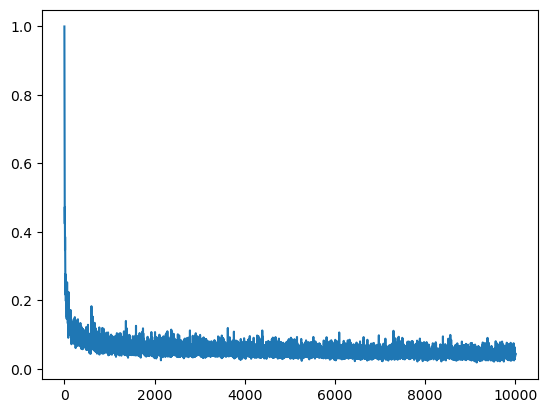

In [14]:
plt.plot(l_losses)

In [15]:
eps_network.eval();

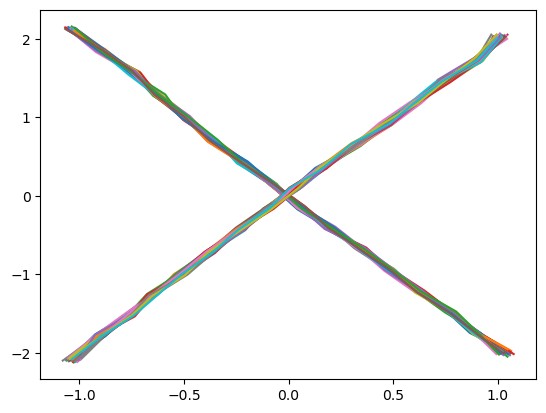

In [16]:
"""Unconditional"""
with torch.no_grad():
  batch_size = 100
  noise_data = torch.randn(batch_size, data_size_1, data_size_2)

  for t in range(n_timesteps, 0, -1):
    t_l = [t - 1] * batch_size
    noise = torch.randn(batch_size, data_size_1, data_size_2)
    eps_estimate = eps_network(noise_data, t_l)
    noise_data = 1 / alphas[t - 1].sqrt() * (noise_data - betas[t - 1] / one_minus_alphas_bar_sqrt[t - 1] * eps_estimate) + 0.2 * betas[t - 1].sqrt() * noise
    # if t == 1:
    #   noise_data = noise_data - betas[t - 1].sqrt() * noise
    
sampled = noise_data.reshape(-1, 2, n)
sampled_x = sampled[:, 0, :]
sampled_y = sampled[:, 1, :]

# fig = plt.figure()    
# ax = fig.add_subplot(1, 1, 1)
# ax.scatter(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0))

plt.plot(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0));

(-2.5, 2.5)

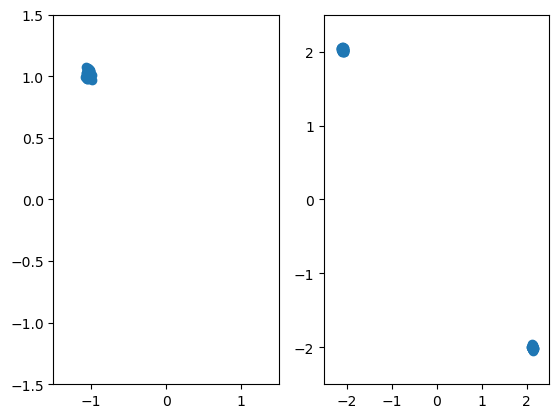

In [17]:
sampled_x_init = sampled[:, 0, 0]
sampled_x_term = sampled[:, 0, n - 1]

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.scatter(sampled_x_init, sampled_x_term)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

sampled_y_init = sampled[:, 1, 0]
sampled_y_term = sampled[:, 1, n - 1]

ax = fig.add_subplot(1, 2, 2)
ax.scatter(sampled_y_init, sampled_y_term)
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

In [ ]:
"""Unconditional"""
with torch.no_grad():
  batch_size = 2
  noise_data = torch.randn(batch_size, data_size_1, data_size_2)

  for t in range(n_timesteps, 0, -1):
    t_l = [t - 1] * batch_size
    noise = torch.randn(batch_size, data_size_1, data_size_2)
    eps_estimate = eps_network(noise_data, t_l)
    noise_data = 1 / alphas[t - 1].sqrt() * (noise_data - betas[t - 1] / one_minus_alphas_bar_sqrt[t - 1] * eps_estimate) + 0.2 * betas[t - 1].sqrt() * noise
    # if t == 1:
    #   noise_data = noise_data - betas[t - 1].sqrt() * noise
    
sampled = noise_data.reshape(-1, 2, n)
sampled_x = sampled[:, 0, :]
sampled_y = sampled[:, 1, :]

# fig = plt.figure()    
# ax = fig.add_subplot(1, 1, 1)
# ax.scatter(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0))

plt.plot(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0))

In [ ]:
"""Unconditional"""
fig = plt.figure()

with torch.no_grad():
  batch_size = 1
  noise_data = torch.randn(batch_size, data_size_1, data_size_2)

  for t in range(n_timesteps, 0, -1):
    t_l = [t - 1] * batch_size
    noise = torch.randn(batch_size, data_size_1, data_size_2)
    eps_estimate = eps_network(noise_data, t_l)
    noise_data = 1 / alphas[t - 1].sqrt() * (noise_data - betas[t - 1] / one_minus_alphas_bar_sqrt[t - 1] * eps_estimate) + 0.2 * betas[t - 1].sqrt() * noise
    if t % 100 == 0:
        idx = int((n_timesteps - t) / 100) + 1
        ax = fig.add_subplot(4, 3, idx)
        sampled_med = noise_data.reshape(-1, 2, n)
        sampled_med_x = sampled_med[:, 0, :]
        sampled_med_y = sampled_med[:, 1, :]
        ax.scatter(sampled_med_x.transpose(1, 0), sampled_med_y.transpose(1, 0), s=5)
        plt.xlim([-2.5, 2.5])
        plt.ylim([-2.5, 2.5])
        
    # if t == 1:
    #   noise_data = noise_data - betas[t - 1].sqrt() * noise
    
# sampled = noise_data.reshape(-1, 2, n)
# sampled_x = sampled[:, 0, :]
# sampled_y = sampled[:, 1, :]

# plt.plot(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0))

In [ ]:
import pickle

"""Save model and loss"""
"""
torch.save(eps_network.state_dict(), './Trajectory Diffusion')
with open('Trajectory Diffusion Loss', 'wb') as f1:
    pickle.dump(l_losses, f1)
"""